### 2-bit Identity Comparator
This notebook implements a 2-bit identity comparator with CBLB blocks.

#### Setting up the imports
External libraries + our own models and parameters

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import lib.models as models
from lib.parameters import *

#### Comparator model
Building our comparator model

In [15]:
# We do not understand why this one does not work!!! - Almost certainly issue in not_not_or
def comparator_model(T, state, *params):
    # Read the state
    L_A_0, L_B_0, L_IA_0, L_IB_0, L_I2_0, L_I3_0, L_I4_0, L_I5_0, a_0, b_0, I1_0, I2_0, I3_0, I4_0, I5_0, \
    L_A_1, L_B_1, L_IA_1, L_IB_1, L_I2_1, L_I3_1, L_I4_1, L_I5_1, a_1, b_1, I1_1, I2_1, I3_1, I4_1, I5_1,  \
    L_I6_I5_0, L_I6_I5_1, L_I7, \
    I6, I7 = state
    # Read the params
    delta_L, gamma_A, gamma_B, n_a, n_b, theta_A, theta_B, eta_a, eta_b, omega_a, omega_b, m_a, m_b, delta_a, delta_b, rho_a, rho_b = params
    # Create params
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    
    #### CONSTRUCT FIRST XNOR
    
    ### 1. step NEG(NEG(A) v NEG(B))

    # Inner part (OR)
    # Prepare state for or
    state_or = L_IA_0, L_IB_0, a_0, b_0, I1_0
    dL_IA_0, dL_IB_0, dI1_0 = models.not_not_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I2_0, I2_0, I1_0
    dL_I2_0, dI2_0 = models.not_cell_wrapper(state_neg, params_neg)

    ### 2. step NEG(A v B)

    # Inner part (OR)
    # Prepare state for or
    state_or = a_0, b_0, I3_0
    dI3_0 = models.yes_yes_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I4_0, I4_0, I3_0
    dL_I4_0, dI4_0 = models.not_cell_wrapper(state_neg, params_neg)

    ### 3. step (I2 v I4)

    # Inner part (OR)
    # Prepare state for or
    state_yes_yes_or = I2_0, I4_0, I5_0
    dI5_0 = models.yes_yes_or(state_yes_yes_or, params_or)

    #### CONSTRUCT SECOND XNOR
    
    ### 1. step NEG(NEG(A) v NEG(B))

    # Inner part (OR)
    # Prepare state for or
    state_or = L_IA_1, L_IB_1, a_1, b_1, I1_1
    dL_IA_1, dL_IB_1, dI1_1 = models.not_not_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I2_1, I2_1, I1_1
    dL_I2_1, dI2_1 = models.not_cell_wrapper(state_neg, params_neg)

    ### 2. step NEG(A v B)

    # Inner part (OR)
    # Prepare state for or
    state_or = a_1, b_1, I3_1
    dI3_1 = models.yes_yes_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I4_1, I4_1, I3_1
    dL_I4_1, dI4_1 = models.not_cell_wrapper(state_neg, params_neg)

    ### 3. step (I2 v I4)

    # Inner part (OR)
    # Prepare state for or
    state_yes_yes_or = I2_1, I4_1, I5_1
    dI5_1 = models.yes_yes_or(state_yes_yes_or, params_or)

    ### Combine the results -> not_not_or + neg

    # Not not or
    state_or = L_I6_I5_0, L_I6_I5_1, I5_0, I5_1, I6
    dL_I6_I5_0, dL_I6_I5_1, dI6 = models.not_not_or(state_or, params_or)

    # Neg
    state_neg = L_I7, I7, I6
    dL_I7, dI7 = models.not_cell_wrapper(state_neg, params_neg)

    # Set changes of unused variables to 0
    dL_A_0, dL_B_0, dL_I3_0, dL_I5_0, da_0, db_0 = 0, 0, 0, 0, 0, 0
    dL_A_1, dL_B_1, dL_I3_1, dL_I5_1, da_1, db_1 = 0, 0, 0, 0, 0, 0

    # We are finished
    return np.array([dL_A_0, dL_B_0, dL_IA_0, dL_IB_0, dL_I2_0, dL_I3_0, dL_I4_0, dL_I5_0, da_0, db_0, dI1_0, dI2_0, dI3_0, dI4_0, dI5_0,
                     dL_A_1, dL_B_1, dL_IA_1, dL_IB_1, dL_I2_1, dL_I3_1, dL_I4_1, dL_I5_1, da_1, db_1, dI1_1, dI2_1, dI3_1, dI4_1, dI5_1,
                     dL_I6_I5_0, dL_I6_I5_1, dL_I7,
                     dI6, dI7])


### Parameters
Setting the parameters

In [16]:
params = [delta_L,
          gamma_A,
          gamma_A,
          n_a,
          n_a,
          theta_A,
          theta_A,
          eta_a,
          eta_a,
          omega_a,
          omega_a,
          m_a,
          m_a,
          delta_a,
          delta_a,
          0,
          0]

### Testing the model
Running the simulation + Plotting the results

In [26]:
import seaborn as sns
sns.set_theme(style="darkgrid")

Iteration:  A0: 0  A1: 0 B0: 0  B1: 0
Iteration:  A0: 0  A1: 0 B0: 0  B1: 1
Iteration:  A0: 0  A1: 0 B0: 1  B1: 0
Iteration:  A0: 0  A1: 0 B0: 1  B1: 1
Iteration:  A0: 0  A1: 1 B0: 0  B1: 0
Iteration:  A0: 0  A1: 1 B0: 0  B1: 1
Iteration:  A0: 0  A1: 1 B0: 1  B1: 0
Iteration:  A0: 0  A1: 1 B0: 1  B1: 1
Iteration:  A0: 1  A1: 0 B0: 0  B1: 0
Iteration:  A0: 1  A1: 0 B0: 0  B1: 1
Iteration:  A0: 1  A1: 0 B0: 1  B1: 0
Iteration:  A0: 1  A1: 0 B0: 1  B1: 1
Iteration:  A0: 1  A1: 1 B0: 0  B1: 0
Iteration:  A0: 1  A1: 1 B0: 0  B1: 1
Iteration:  A0: 1  A1: 1 B0: 1  B1: 0
Iteration:  A0: 1  A1: 1 B0: 1  B1: 1


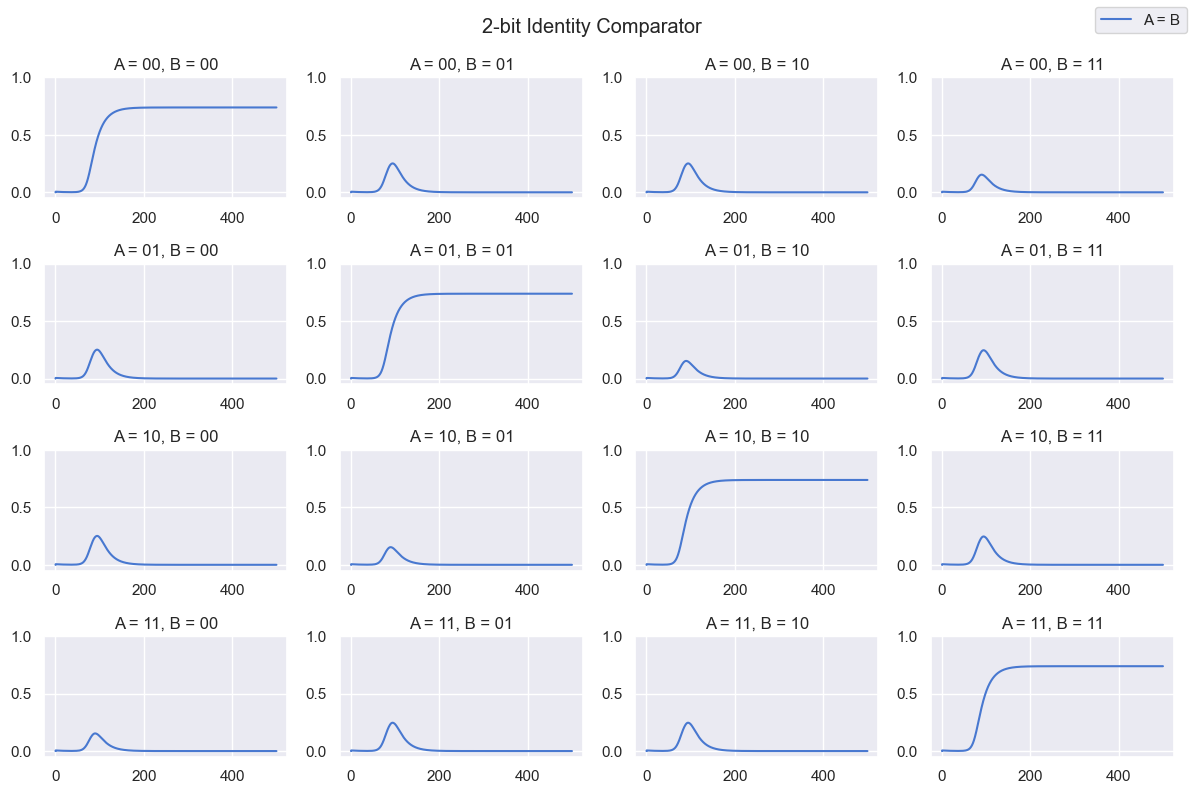

In [54]:
t_end = 500
N = t_end * 10
T = np.linspace(0, t_end, N)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
iteration_a = -1
iteration_b = 0
for A0 in range(2):
    for A1 in range(2):
        iteration_a += 1
        iteration_b = 0
        for B0 in range(2):
            for B1 in range(2):
                print("Iteration: ", "A0:", A0, " A1:", A1, "B0:", B0, " B1:", B1)
                Y0 = np.zeros(35)
                Y0[8] = A0
                Y0[9] = B0
                Y0[23] = A1
                Y0[24] = B1
                sol = solve_ivp(comparator_model, [0, t_end], Y0, args=params, dense_output=True)
                z = sol.sol(T)
                # Value of A = B
                a_equal_b = z.T[:, 34]
                #ax.plot(T, value_a, color="red", label="A")
                #ax.plot(T, value_b, color="blue", label="B")
                # ax.set_ylim(bottom=0, top=1)
                ax[iteration_a, iteration_b].set_ylim(bottom=-0.05, top=1)
                if iteration_a == 0 and iteration_b == 0:
                    ax[iteration_a, iteration_b].plot(T, a_equal_b, color=sns.color_palette("muted")[0], label="A = B")
                else:
                    ax[iteration_a, iteration_b].plot(T, a_equal_b, color=sns.color_palette("muted")[0])
                # ax[iteration_a, iteration_b].legend()
                title = "A = {a0_bit}{a1_bit}, B = {b0_bit}{b1_bit}".format(a0_bit = A0, b0_bit = B0, a1_bit = A1, b1_bit = B1)
                ax[iteration_a, iteration_b].set_title(title)
                iteration_b += 1
filename = "slike/2_bit_identity_comparator/png/comparator_simulation"
fig.suptitle("2-bit Identity Comparator")
fig.tight_layout()
fig.legend()
fig.savefig(filename)